# Fake News Detection

Link to Dataset
https://www.kaggle.com/jruvika/fake-news-detection

In [1]:
#import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


### Read Dataset 

Dowload the datset from kaggle and read it here and assigned the dataset into a dataframe named df and viewed the data to have an idea.

In [2]:
#read csv file and retrieve data
df = pd.read_csv('data.csv')

In [3]:
df.head()


URLs  \
0  http://www.bbc.com/news/world-us-canada-414191...   
1  https://www.reuters.com/article/us-filmfestiva...   
2  https://www.nytimes.com/2017/10/09/us/politics...   
3  https://www.reuters.com/article/us-mexico-oil-...   
4  http://www.cnn.com/videos/cnnmoney/2017/10/08/...   

                                            Headline  \
0         Four ways Bob Corker skewered Donald Trump   
1  Linklater's war veteran comedy speaks to moder...   
2  Trump’s Fight With Corker Jeopardizes His Legi...   
3  Egypt's Cheiron wins tie-up with Pemex for Mex...   
4        Jason Aldean opens 'SNL' with Vegas tribute   

                                                Body  Label  
0  Image copyright Getty Images\nOn Sunday mornin...      1  
1  LONDON (Reuters) - “Last Flag Flying”, a comed...      1  
2  The feud broke into public view last week when...      1  
3  MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...      1  
4  Country singer Jason Aldean, who was performin...      1

In [4]:
#view rows and columns
print(df.shape)

print(df.info())

(4009, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
URLs        4009 non-null object
Headline    4009 non-null object
Body        3988 non-null object
Label       4009 non-null int64
dtypes: int64(1), object(3)
memory usage: 125.4+ KB
None


In [5]:
#view rows and columns
print(df.shape)

(4009, 4)


## Visualizing Data

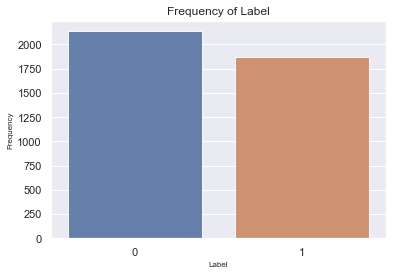

In [6]:
label_count = df["Label"].value_counts()
sns.set(style="darkgrid")
sns.barplot(label_count.index, label_count.values, alpha=0.9)
plt.title("Frequency of Label")
plt.ylabel("Frequency", fontsize=8)
plt.xlabel("Label", fontsize=8)
plt.show()

In [7]:
df.Label.value_counts()

0    2137
1    1872
Name: Label, dtype: int64

In [8]:
#delete URLs column as we dont need it for the classification

del df['URLs']

In [9]:
df.head()

Headline  \
0         Four ways Bob Corker skewered Donald Trump   
1  Linklater's war veteran comedy speaks to moder...   
2  Trump’s Fight With Corker Jeopardizes His Legi...   
3  Egypt's Cheiron wins tie-up with Pemex for Mex...   
4        Jason Aldean opens 'SNL' with Vegas tribute   

                                                Body  Label  
0  Image copyright Getty Images\nOn Sunday mornin...      1  
1  LONDON (Reuters) - “Last Flag Flying”, a comed...      1  
2  The feud broke into public view last week when...      1  
3  MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...      1  
4  Country singer Jason Aldean, who was performin...      1

### Combine Headline and Body columns

A news article has 2 sections as Headline and Body. In this dataset Headline and the Body are in 2 separated columns. So we combined those 2 columns (Headline column and Body column) into 1 column and named it as Headline_Body.

In [10]:
#combine Headline and Body columns
df['Headline_Body'] = df['Headline'].astype(str)+' '+df['Body']

#view new dataset
df

Headline  \
0            Four ways Bob Corker skewered Donald Trump   
1     Linklater's war veteran comedy speaks to moder...   
2     Trump’s Fight With Corker Jeopardizes His Legi...   
3     Egypt's Cheiron wins tie-up with Pemex for Mex...   
4           Jason Aldean opens 'SNL' with Vegas tribute   
...                                                 ...   
4004                                    Trends to Watch   
4005  Trump Jr. Is Soon To Give A 30-Minute Speech F...   
4006        Ron Paul on Trump, Anarchism & the AltRight   
4007  China to accept overseas trial data in bid to ...   
4008  Vice President Mike Pence Leaves NFL Game Beca...   

                                                   Body  Label  \
0     Image copyright Getty Images\nOn Sunday mornin...      1   
1     LONDON (Reuters) - “Last Flag Flying”, a comed...      1   
2     The feud broke into public view last week when...      1   
3     MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...      1   
4     Country singer Jason Aldean, who was performin...      1   
...                                                 ...    ...   
4004  Trends to Watch\n% of readers think this story...      0   
4005  Trump Jr. Is Soon To Give A 30-Minute Speech F...      0   
4006                                                NaN      0   
4007  SHANGHAI (Reuters) - China said it plans to ac...      1   
4008  Vice President Mike Pence Leaves NFL Game Beca...      0   

                                          Headline_Body  
0     Four ways Bob Corker skewered Donald Trump Ima...  
1     Linklater's war veteran comedy speaks to moder...  
2     Trump’s Fight With Corker Jeopardizes His Legi...  
3     Egypt's Cheiron wins tie-up with Pemex for Mex...  
4     Jason Aldean opens 'SNL' with Vegas tribute Co...  
...                                                 ...  
4004  Trends to Watch Trends to Watch\n% of readers ...  
4005  Trump Jr. Is Soon To Give A 30-Minute Speech F...  
4006                                                NaN  
4007  China to accept overseas trial data in bid to ...  
4008  Vice President Mike Pence Leaves NFL Game Beca...  

[4009 rows x 4 columns]

### Select the columns, we are going to use

Select Headline_Body and Label columns and save it to a new dataframe 

In [11]:
#retrieve needed columns to a dataframe

data = df[["Headline_Body", "Label"]]
data

Headline_Body  Label
0     Four ways Bob Corker skewered Donald Trump Ima...      1
1     Linklater's war veteran comedy speaks to moder...      1
2     Trump’s Fight With Corker Jeopardizes His Legi...      1
3     Egypt's Cheiron wins tie-up with Pemex for Mex...      1
4     Jason Aldean opens 'SNL' with Vegas tribute Co...      1
...                                                 ...    ...
4004  Trends to Watch Trends to Watch\n% of readers ...      0
4005  Trump Jr. Is Soon To Give A 30-Minute Speech F...      0
4006                                                NaN      0
4007  China to accept overseas trial data in bid to ...      1
4008  Vice President Mike Pence Leaves NFL Game Beca...      0

[4009 rows x 2 columns]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 2 columns):
Headline_Body    3988 non-null object
Label            4009 non-null int64
dtypes: int64(1), object(1)
memory usage: 62.8+ KB


In [13]:
#view data in Total column by idnex

data['Headline_Body'][0]

'Four ways Bob Corker skewered Donald Trump Image copyright Getty Images\nOn Sunday morning, Donald Trump went off on a Twitter tirade against a member of his own party.\nThis, in itself, isn\'t exactly huge news. It\'s far from the first time the president has turned his rhetorical cannons on his own ranks.\nThis time, however, his attacks were particularly biting and personal. He essentially called Tennessee Senator Bob Corker, the chair of the powerful Senate Foreign Relations Committee, a coward for not running for re-election.\nHe said Mr Corker "begged" for the president\'s endorsement, which he refused to give. He wrongly claimed that Mr Corker\'s support of the Iranian nuclear agreement was his only political accomplishment.\nUnlike some of his colleagues, Mr Corker - free from having to worry about his immediate political future - didn\'t hold his tongue.\nSkip Twitter post by @SenBobCorker It\'s a shame the White House has become an adult day care center. Someone obviously mi

### View and remove null values

For a higher accuracy we have to remove the null values. Below codes are to find out how many null values are there and to drop those vales

In [14]:
print(data.isnull().sum())

Headline_Body    21
Label             0
dtype: int64


In [15]:
#Delete rows with null value since it's small and won't affect the dataset
data = data.dropna(how='any',axis=0)

In [16]:
print(data.isnull().sum())

Headline_Body    0
Label            0
dtype: int64


In [17]:
# # Covert all text as lowercase
# data['Headline_Body'] = data['Headline_Body'].str.lower()

## Remove Special Characters

In [18]:
#stemming using snowball stemmer
meth_Snow= nltk.stem.SnowballStemmer('english')
#separate stop words
stopW = set(stopwords.words('english'))

In [19]:
#Function for Remove the tags
def CleanTags(line): 
    c = re.compile('<.*?>')
    cleanline = re.sub(c, ' ', line)
    return cleanline

In [20]:
#Function for cleaning words of punctuation or special characters
def CleanWords(line): 
    cleanedline = re.sub(r'[?|!|\'|"|#]',r'',line)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleanedline)
    return  cleaned

In [21]:
i = 0

str1 = ' '
final_string = []
s = ''

for sent in data['Headline_Body'].values:
    filtered_sentence = []
    
    # Remove HTMl tags
    sent = CleanTags(sent) 
    for w in sent.split():
        for cleaned_words in CleanWords(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):    
                if(cleaned_words.lower() not in stopW):
                    s = (meth_Snow.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)                    
                else:
                    continue
            else:
                continue 
  
    str1 = b" ".join(filtered_sentence) 
    
    str1 = str1.decode('utf-8')
    
    #final string of cleaned words
    final_string.append(str1)
    i += 1 

In [22]:
data['Cleaned_Headline_Body'] = final_string
data.head()

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Headline_Body  Label  \
0  Four ways Bob Corker skewered Donald Trump Ima...      1   
1  Linklater's war veteran comedy speaks to moder...      1   
2  Trump’s Fight With Corker Jeopardizes His Legi...      1   
3  Egypt's Cheiron wins tie-up with Pemex for Mex...      1   
4  Jason Aldean opens 'SNL' with Vegas tribute Co...      1   

                               Cleaned_Headline_Body  
0  four way bob corker skewer donald trump imag c...  
1  linklat war veteran comedi speak modern americ...  
2  fight corker jeopard legisl agenda feud broke ...  
3  egypt cheiron win pemex mexican onshor oil fie...  
4  jason aldean open snl vega tribut countri sing...

In [23]:
data['Cleaned_Headline_Body'][0]

'four way bob corker skewer donald trump imag copyright getti imag sunday morn donald trump went twitter tirad member parti isnt exact huge news far first time presid turn rhetor cannon rank time howev attack particular bite person essenti call tennesse senat bob corker chair power senat foreign relat committe coward run said corker beg presid endors refus give wrong claim corker support iranian nuclear agreement polit accomplish unlik colleagu corker free worri immedi polit futur didnt hold tongu skip twitter post shame white hous becom adult day care center someon obvious miss shift morn senat bob corker octob report wasnt end though spoke new york time realli let presid four choic quot tennesse senat interview time particular damn dont know presid tweet thing true know everyon know cant realli sugarcoat one corker say presid liar everyon know senat particular challeng trump insist unsuccess plead endors accus much broader corker presid use someth akin alli tennessean trump short lis

### Divide dataset into training and testing sets

In [24]:
x1 = np.asarray(data['Cleaned_Headline_Body'])
y1 = np.asarray(data['Label'])

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state = 0)

In [76]:
x_test

array(['fantasi footbal idp rank week warn someth big happen america martial law come chanc happen red list blue list',
       'air franc engin damag make emerg land video embattl pharmaceut compani sell power painkil fentanyl donat campaign oppos pot legal campaign say truli shock video',
       'nato launch black sea forc latest counter russia craiova romania reuter nato launch new multin forc romania monday counter russia along eastern flank check grow russian presenc black sea follow seizur crimea forc initi built around romanian brigad soldier support troop nine nato countri complement separ deploy troop alreadi place plan includ addit air sea asset give forc greater capabl purpos peac war romanian presid klaus iohanni told nato parliamentari assembl allianc lawmak meet year bucharest threat russia need dialogu strong posit defens discourag said fli craiova militari base romania base militari band play nato jen stoltenberg stood alongsid iohanni address troop green face paint insp

In [78]:
print(x_test.shape)
type(x_test)

(798,)


numpy.ndarray

### Vectorize Tokens

In [27]:
#import libraries to Convert the tokens into tf-idf weights and 
#then normalize the term vectors



In [28]:
#vectorize
tf_idf_Vector = TfidfVectorizer()

## fitting with train_x set
tf_idf_TrainSet = tf_idf_Vector.fit_transform(x_train)
tf_idf_TestSet = tf_idf_Vector.transform(x_test)

In [29]:
tf_idf_TrainSet

<3190x26103 sparse matrix of type '<class 'numpy.float64'>'
	with 517899 stored elements in Compressed Sparse Row format>

In [63]:
type(tf_idf_TestSet)

scipy.sparse.csr.csr_matrix

# KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier
    
classifier = KNeighborsClassifier(n_neighbors=19)
classifier.fit(tf_idf_TrainSet, y_train)
    
knn_pred = classifier.predict(tf_idf_TestSet)
    
knn_prob = classifier.predict_proba(tf_idf_TestSet)
    
print(confusion_matrix(y_test,knn_pred))
        
print(classification_report(y_test, knn_pred, digits = 3))
    
    
    
print("accuracy: ", accuracy_score(y_test, knn_pred))
    
print("roc_auc_score: ", sklearn.metrics.roc_auc_score(y_test,knn_pred))

[[395  39]
 [ 22 342]]
              precision    recall  f1-score   support

           0      0.947     0.910     0.928       434
           1      0.898     0.940     0.918       364

    accuracy                          0.924       798
   macro avg      0.922     0.925     0.923       798
weighted avg      0.925     0.924     0.924       798

accuracy:  0.9235588972431078
roc_auc_score:  0.924849344204183


# Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
    
logreg = LogisticRegression()
# logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
logreg.fit(tf_idf_TrainSet, y_train)
    
log_pred = logreg.predict(tf_idf_TestSet)
    
log_prob = logreg.predict_proba(tf_idf_TestSet)
    
print(confusion_matrix(y_test,log_pred))
    
print(classification_report(y_test, log_pred, digits = 3))
    
    
    
print("accuracy: ", accuracy_score(y_test,log_pred))
    
print("roc_auc_score: ", sklearn.metrics.roc_auc_score(y_test,log_pred))

[[422  12]
 [  6 358]]
              precision    recall  f1-score   support

           0      0.986     0.972     0.979       434
           1      0.968     0.984     0.975       364

    accuracy                          0.977       798
   macro avg      0.977     0.978     0.977       798
weighted avg      0.978     0.977     0.977       798

accuracy:  0.9774436090225563
roc_auc_score:  0.9779333569656151


In [33]:
tf_idf_TrainSet1 = tf_idf_Vector.fit_transform(x1)

In [34]:
from sklearn.ensemble import RandomForestClassifier

    
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(tf_idf_TrainSet,y_train)
    
rand_pred = forest.predict(tf_idf_TestSet)
    
#rand_prob = forest.predict_proba(x_test)[:,1]
rand_prob = forest.predict_proba(tf_idf_TestSet)
    
print(confusion_matrix(y_test,rand_pred))
    
print(metrics.classification_report(y_test,rand_pred, digits=3))
print("accuracy: ", accuracy_score(y_test, rand_pred))
    
    
print('auc_roc_score: ', roc_auc_score(y_test, rand_pred))

[[411  23]
 [  1 363]]
              precision    recall  f1-score   support

           0      0.998     0.947     0.972       434
           1      0.940     0.997     0.968       364

    accuracy                          0.970       798
   macro avg      0.969     0.972     0.970       798
weighted avg      0.972     0.970     0.970       798

accuracy:  0.9699248120300752
auc_roc_score:  0.972128677773839


In [35]:
from sklearn.tree import DecisionTreeClassifier
    
    
tree = DecisionTreeClassifier(random_state=0)
tree.fit(tf_idf_TrainSet, y_train)
    
tree_pred = tree.predict(tf_idf_TestSet)
    
tree_prob = tree.predict_proba(tf_idf_TestSet)
    
print(confusion_matrix(y_test,tree_pred))
    
print(metrics.classification_report(y_test, tree_pred, digits=3))
    
print('accuracy: ', accuracy_score(y_test, tree_pred))

print('auc_roc_score: ', roc_auc_score(y_test, tree_pred))

[[413  21]
 [ 22 342]]
              precision    recall  f1-score   support

           0      0.949     0.952     0.951       434
           1      0.942     0.940     0.941       364

    accuracy                          0.946       798
   macro avg      0.946     0.946     0.946       798
weighted avg      0.946     0.946     0.946       798

accuracy:  0.9461152882205514
auc_roc_score:  0.945586671393123


In [64]:
from sklearn.ensemble import GradientBoostingClassifier
    
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
# gradient_booster.get_params()
    
gradient_booster.fit(tf_idf_TrainSet, y_train)
    
grad_pred = gradient_booster.predict(tf_idf_TestSet)
    
grad_prob = gradient_booster.predict_proba(tf_idf_TestSet)
    
print(confusion_matrix(y_test, grad_pred))
    
print(classification_report(y_test, grad_pred, digits=3))
    
print('accuracy: ', accuracy_score(y_test, grad_pred))
    
print('auc_roc_score: ', roc_auc_score(y_test, grad_pred))

[[428   6]
 [  6 358]]
              precision    recall  f1-score   support

           0      0.986     0.986     0.986       434
           1      0.984     0.984     0.984       364

    accuracy                          0.985       798
   macro avg      0.985     0.985     0.985       798
weighted avg      0.985     0.985     0.985       798

accuracy:  0.9849624060150376
auc_roc_score:  0.9848457993619284


In [37]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(tf_idf_TrainSet, y_train)
    
# make predictions for test data
xg_pred = xg.predict(tf_idf_TestSet)
    
xg_prob = xg.predict_proba(tf_idf_TestSet)
    
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print(\Accuracy: %.2f%%\ % (accuracy * 100.0))
    
print(confusion_matrix(y_test, xg_pred))
    
print(classification_report(y_test, xg_pred, digits=3))
    
print('accuracy: ', accuracy_score(y_test, xg_pred))
    
print('auc_roc_score: ', roc_auc_score(y_test,xg_pred))

C:\Users\Lenovo\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:34:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[425   9]
 [  7 357]]
              precision    recall  f1-score   support

           0      0.984     0.979     0.982       434
           1      0.975     0.981     0.978       364

    accuracy                          0.980       798
   macro avg      0.980     0.980     0.980       798
weighted avg      0.980     0.980     0.980       798

accuracy:  0.9799498746867168
auc_roc_score:  0.9800159517901454


# Perform Classification on New Data

In [38]:
#read csv file and retrieve data
newData = pd.read_csv('fake_or_real_news.csv')

In [39]:
newData.head()


Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL

In [40]:
#view rows and columns
print(newData.shape)
print("=========")
print(newData.info())

(6335, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None


In [41]:
LabelCol = newData.iloc[:,3]

In [42]:
del newData['Unnamed: 0']
del newData['label']

In [43]:
newData.head()

title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text  
0  Daniel Greenfield, a Shillman Journalism Fello...  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  
2  U.S. Secretary of State John F. Kerry said Mon...  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  
4  It's primary day in New York and front-runners...

### Combine Headline and Body columns

In [44]:
#combine Headline and Body columns
newData['Headline_Body'] = newData['title'].astype(str)+' '+newData['text']

#view new dataset
newData

title  \
0                          You Can Smell Hillary’s Fear   
1     Watch The Exact Moment Paul Ryan Committed Pol...   
2           Kerry to go to Paris in gesture of sympathy   
3     Bernie supporters on Twitter erupt in anger ag...   
4      The Battle of New York: Why This Primary Matters   
...                                                 ...   
6330  State Department says it can't find emails fro...   
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332  Anti-Trump Protesters Are Tools of the Oligarc...   
6333  In Ethiopia, Obama seeks progress on peace, se...   
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text  \
0     Daniel Greenfield, a Shillman Journalism Fello...   
1     Google Pinterest Digg Linkedin Reddit Stumbleu...   
2     U.S. Secretary of State John F. Kerry said Mon...   
3     — Kaydee King (@KaydeeKing) November 9, 2016 T...   
4     It's primary day in New York and front-runners...   
...                                                 ...   
6330  The State Department told the Republican Natio...   
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332   Anti-Trump Protesters Are Tools of the Oligar...   
6333  ADDIS ABABA, Ethiopia —President Obama convene...   
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                          Headline_Body  
0     You Can Smell Hillary’s Fear Daniel Greenfield...  
1     Watch The Exact Moment Paul Ryan Committed Pol...  
2     Kerry to go to Paris in gesture of sympathy U....  
3     Bernie supporters on Twitter erupt in anger ag...  
4     The Battle of New York: Why This Primary Matte...  
...                                                 ...  
6330  State Department says it can't find emails fro...  
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...  
6332  Anti-Trump Protesters Are Tools of the Oligarc...  
6333  In Ethiopia, Obama seeks progress on peace, se...  
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...  

[6335 rows x 3 columns]

### Select the columns, we are going to use

Select Headline_Body and Label columns and save it to a new dataframe 

In [45]:
#retrieve needed columns to a dataframe

data1 = newData[["Headline_Body"]]
data1

Headline_Body
0     You Can Smell Hillary’s Fear Daniel Greenfield...
1     Watch The Exact Moment Paul Ryan Committed Pol...
2     Kerry to go to Paris in gesture of sympathy U....
3     Bernie supporters on Twitter erupt in anger ag...
4     The Battle of New York: Why This Primary Matte...
...                                                 ...
6330  State Department says it can't find emails fro...
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332  Anti-Trump Protesters Are Tools of the Oligarc...
6333  In Ethiopia, Obama seeks progress on peace, se...
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...

[6335 rows x 1 columns]

### View and remove null values

In [46]:
print(data1.isnull().sum())

Headline_Body    0
dtype: int64


In [47]:
i = 0

str1 = ' '
final_string = []
s = ''

for sent in data1['Headline_Body'].values:
    filtered_sentence = []
    
    # Remove HTMl tags
    sent = CleanTags(sent) 
    for w in sent.split():
        for cleaned_words in CleanWords(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):    
                if(cleaned_words.lower() not in stopW):
                    s = (meth_Snow.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)                    
                else:
                    continue
            else:
                continue 
  
    str1 = b" ".join(filtered_sentence) 
    
    str1 = str1.decode('utf-8')
    
    #final string of cleaned words
    final_string.append(str1)
    i += 1 


In [48]:
data1['Cleaned_Headline_Body'] = final_string
data1.head()

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Headline_Body  \
0  You Can Smell Hillary’s Fear Daniel Greenfield...   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2  Kerry to go to Paris in gesture of sympathy U....   
3  Bernie supporters on Twitter erupt in anger ag...   
4  The Battle of New York: Why This Primary Matte...   

                               Cleaned_Headline_Body  
0  smell fear daniel greenfield shillman journal ...  
1  watch exact moment paul ryan commit polit suic...  
2  kerri pari gestur sympathi secretari state joh...  
3  berni support twitter erupt anger tri warn kay...  
4  battl new primari matter primari day new york ...

In [49]:
del data1['Headline_Body']

In [50]:
data1

Cleaned_Headline_Body
0     smell fear daniel greenfield shillman journal ...
1     watch exact moment paul ryan commit polit suic...
2     kerri pari gestur sympathi secretari state joh...
3     berni support twitter erupt anger tri warn kay...
4     battl new primari matter primari day new york ...
...                                                 ...
6330  state depart say cant find email clinton speci...
6331  pbs stand pbs stand post oct wikimedia televis...
6332  protest tool oligarchi inform protest tool oli...
6333  ethiopia obama seek progress peac secur east a...
6334  jeb bush sudden attack trump here matter jeb b...

[6335 rows x 1 columns]

In [85]:
list1 = data1['Cleaned_Headline_Body'].astype(str).values.tolist()
list1

['smell fear daniel greenfield shillman journal fellow freedom center new york writer focus radic islam final stretch elect hillari rodham clinton gone war fbi word thrown around often elect ought retir still unpreced nomine major polit parti war fbi exact hillari peopl done coma patient wake watch hour cnn hospit bed would assum fbi director jame comey oppon elect fbi attack everyon obama cnn peopl circul letter attack comey current media hit piec lambast target trump surpris clinton alli start run attack ad fbi leadership warn entir establish form lynch mob continu go hillari credibl attack media democrat preemptiv head result investig clinton foundat hillari clinton covert struggl fbi agent doj peopl gone explos public new york time compar comey edgar hoover bizarr headlin comey role recal fbi fair practic admit front spout nonsens boston globe publish column call resign outdon time editori claim scandal realli attack women jame carvill appear msnbc remind everyon still aliv insan a

In [87]:
newDataArray = np.array(list1)

In [88]:
newDataArray

array(['smell fear daniel greenfield shillman journal fellow freedom center new york writer focus radic islam final stretch elect hillari rodham clinton gone war fbi word thrown around often elect ought retir still unpreced nomine major polit parti war fbi exact hillari peopl done coma patient wake watch hour cnn hospit bed would assum fbi director jame comey oppon elect fbi attack everyon obama cnn peopl circul letter attack comey current media hit piec lambast target trump surpris clinton alli start run attack ad fbi leadership warn entir establish form lynch mob continu go hillari credibl attack media democrat preemptiv head result investig clinton foundat hillari clinton covert struggl fbi agent doj peopl gone explos public new york time compar comey edgar hoover bizarr headlin comey role recal fbi fair practic admit front spout nonsens boston globe publish column call resign outdon time editori claim scandal realli attack women jame carvill appear msnbc remind everyon still aliv i

In [89]:
print(newDataArray.shape)
type(newDataArray)

(6335,)


numpy.ndarray

In [90]:
tf_idf_New = tf_idf_Vector.transform(newDataArray)

In [91]:
type(tf_idf_New)

scipy.sparse.csr.csr_matrix

In [93]:
grad_pred = gradient_booster.predict(tf_idf_New)

ValueError: X has 1 features, but DecisionTreeRegressor is expecting 26103 features as input.

In [69]:
# other1 = np.asarray(data1)
# other1

In [92]:
grad_pred = gradient_booster.predict(tf_idf_New)

i1 = []

d1 = []

c1 = []

for i in range(len(data1)):
    d1.append(data1[i])
    c1.append(new_output1[i])
    
    print(data1[i],new_output1[i])

ValueError: X has 1 features, but DecisionTreeRegressor is expecting 26103 features as input.

In [ ]:
gradient_booster.predict(tf_idf_TestSet)